<a href="https://colab.research.google.com/github/HesterFrederiek/Hackaton_Zurich/blob/master/geodaten.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages 

In [1]:
import json
import pandas as pd
import io
import requests
import matplotlib.pyplot as plt
import numpy as np
import datetime

In [2]:
!pip install geopandas

     |████████████████████████████████| 1.0 MB 5.2 MB/s 
     |████████████████████████████████| 6.3 MB 37.3 MB/s 
     |████████████████████████████████| 15.4 MB 38 kB/s 


In [3]:
import geopandas
from shapely.geometry import Point, Polygon

# Code to flatten nested json file 

Code copied from: https://stackoverflow.com/questions/39899005/how-to-flatten-a-pandas-dataframe-with-some-columns-as-json

In [4]:
def flatten_nested_json_df(df):

    df = df.reset_index()

    print(f"original shape: {df.shape}")
    print(f"original columns: {df.columns}")


    # search for columns to explode/flatten
    s = (df.applymap(type) == list).all()
    list_columns = s[s].index.tolist()

    s = (df.applymap(type) == dict).all()
    dict_columns = s[s].index.tolist()

    print(f"lists: {list_columns}, dicts: {dict_columns}")
    while len(list_columns) > 0 or len(dict_columns) > 0:
        new_columns = []

        for col in dict_columns:
            print(f"flattening: {col}")
            # explode dictionaries horizontally, adding new columns
            horiz_exploded = pd.json_normalize(df[col]).add_prefix(f'{col}.')
            horiz_exploded.index = df.index
            df = pd.concat([df, horiz_exploded], axis=1).drop(columns=[col])
            new_columns.extend(horiz_exploded.columns) # inplace

        for col in list_columns:
            print(f"exploding: {col}")
            # explode lists vertically, adding new columns
            df = df.drop(columns=[col]).join(df[col].explode().to_frame())
            new_columns.append(col)

        # check if there are still dict o list fields to flatten
        s = (df[new_columns].applymap(type) == list).all()
        list_columns = s[s].index.tolist()

        s = (df[new_columns].applymap(type) == dict).all()
        dict_columns = s[s].index.tolist()

        print(f"lists: {list_columns}, dicts: {dict_columns}")

    print(f"final shape: {df.shape}")
    print(f"final columns: {df.columns}")
    return df

# Import data bfe ladestellen

In [5]:
url = 'https://data.geo.admin.ch/ch.bfe.ladestellen-elektromobilitaet/data/oicp/ch.bfe.ladestellen-elektromobilitaet.json'

In [6]:
data = requests.get(url).json()

df = pd.DataFrame(data["EVSEData"])

# Extract locations of charging stations


In [7]:
df2 = pd.json_normalize(data["EVSEData"])

In [8]:
df_flat = flatten_nested_json_df(df2)
df_flat = df_flat.reset_index()
addresses = df_flat["EVSEDataRecord"]
# get geocoordinates of charging station (here for the first one): [float(x) for x in addresses[0]["GeoCoordinates"]['Google'].split()

original shape: (31, 4)
original columns: Index(['index', 'EVSEDataRecord', 'OperatorID', 'OperatorName'], dtype='object')
lists: ['EVSEDataRecord'], dicts: []
exploding: EVSEDataRecord
lists: [], dicts: []
final shape: (6609, 4)
final columns: Index(['index', 'OperatorID', 'OperatorName', 'EVSEDataRecord'], dtype='object')


# Import geojson "Statistische Raumeinheiten: Wohnviertel" from open data portal bs



In [9]:
url = "https://data.bs.ch/explore/dataset/100042/download/?format=geojson&timezone=Europe/Berlin&lang=de"

In [10]:
gdf = geopandas.read_file(url)

# Explore data

In [11]:
gdf

,wov_id,wov_name,gemeinde_name,wov_label,geometry
0,02,Vorstädte,Basel,2,"POLYGON ((7.58713 47.55098, 7.58710 47.55104, ..."
1,05,St. Alban,Basel,5,"POLYGON ((7.60569 47.53056, 7.60558 47.53042, ..."
2,06,Gundeldingen,Basel,6,"POLYGON ((7.60405 47.53743, 7.60410 47.53733, ..."
3,07,Bruderholz,Basel,7,"POLYGON ((7.59484 47.51934, 7.59479 47.51930, ..."
4,08,Bachletten,Basel,8,"POLYGON ((7.57632 47.54392, 7.57601 47.54394, ..."
5,09,Gotthelf,Basel,9,"POLYGON ((7.57421 47.55335, 7.57411 47.55333, ..."
6,14,Wettstein,Basel,14,"POLYGON ((7.60231 47.55683, 7.60072 47.55676, ..."
7,16,Rosental,Basel,16,"POLYGON ((7.60031 47.56223, 7.60018 47.56216, ..."
8,01,Altstadt Grossbasel,Basel,1,"POLYGON ((7.59539 47.55581, 7.59552 47.55576, ..."
9,03,Am Ring,Basel,3,"POLYGON ((7.58553 47.55216, 7.58584 47.55206, ..."


In [12]:
gdf.geometry

0     POLYGON ((7.58713 47.55098, 7.58710 47.55104, ...
1     POLYGON ((7.60569 47.53056, 7.60558 47.53042, ...
2     POLYGON ((7.60405 47.53743, 7.60410 47.53733, ...
3     POLYGON ((7.59484 47.51934, 7.59479 47.51930, ...
4     POLYGON ((7.57632 47.54392, 7.57601 47.54394, ...
5     POLYGON ((7.57421 47.55335, 7.57411 47.55333, ...
6     POLYGON ((7.60231 47.55683, 7.60072 47.55676, ...
7     POLYGON ((7.60031 47.56223, 7.60018 47.56216, ...
8     POLYGON ((7.59539 47.55581, 7.59552 47.55576, ...
9     POLYGON ((7.58553 47.55216, 7.58584 47.55206, ...
10    POLYGON ((7.62252 47.54272, 7.62250 47.54243, ...
11    POLYGON ((7.59071 47.56053, 7.59064 47.56060, ...
12    POLYGON ((7.58596 47.57649, 7.58596 47.57649, ...
13    POLYGON ((7.58707 47.58288, 7.58706 47.58289, ...
14    POLYGON ((7.56475 47.55712, 7.56458 47.55711, ...
15    POLYGON ((7.57364 47.56210, 7.57305 47.56238, ...
16    POLYGON ((7.59783 47.56054, 7.59734 47.56025, ...
17    POLYGON ((7.61369 47.55876, 7.61362 47.558

In [13]:
gdf.geometry.geom_type

0     Polygon
1     Polygon
2     Polygon
3     Polygon
4     Polygon
5     Polygon
6     Polygon
7     Polygon
8     Polygon
9     Polygon
10    Polygon
11    Polygon
12    Polygon
13    Polygon
14    Polygon
15    Polygon
16    Polygon
17    Polygon
18    Polygon
19    Polygon
20    Polygon
dtype: object

In [15]:
point = Point([7.58887566398, 47.5570843667])

In [16]:
type(point)

shapely.geometry.point.Point

In [17]:
type(gdf.geometry[0])

shapely.geometry.polygon.Polygon

In [18]:
polygon = gdf.geometry[0]

In [19]:
polygon.contains(point)

False

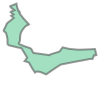

In [20]:
gdf.geometry[0]

# Identify locations of charging stations

Find the charging stations in Basel, checked that I got the same number (67) as Christian (https://github.com/statistikZH/geocoords2spatialunits), checked the lines that gave errors 

In [21]:
k = 0
for i in range(len(addresses)): #range(len(addresses)):
  try: 
    addresses[i]["GeoCoordinates"]['Google'].split()
    #print(i)
    coordinates = [float(x) for x in addresses[i]["GeoCoordinates"]['Google'].split()]
    point = Point(coordinates[1], coordinates[0])
    for j in range(len(gdf.geometry)):
      polygon = gdf.geometry[j]
      if polygon.contains(point):
        print(i, gdf["wov_name"][j], gdf["wov_id"][j])
        k += 1
  except: 
    TypeError
    print("error with " ,i)
print(k)

error with  100
error with  101
435 Rosental 16
436 Rosental 16
653 Hirzbrunnen 15
654 Hirzbrunnen 15
655 Hirzbrunnen 15
656 Hirzbrunnen 15
791 Bettingen 30
792 Bettingen 30
936 Gundeldingen 06
937 Gundeldingen 06
1059 Am Ring 03
1060 Am Ring 03
1135 Vorstädte 02
1136 Vorstädte 02
1137 Vorstädte 02
1138 Altstadt Grossbasel 01
1139 Vorstädte 02
1140 Vorstädte 02
1141 Vorstädte 02
1142 Vorstädte 02
1216 St. Alban 05
1217 St. Alban 05
1262 Riehen 20
1263 Riehen 20
1268 Gundeldingen 06
1269 Gundeldingen 06
1272 St. Alban 05
1273 St. Alban 05
1274 St. Alban 05
1275 St. Alban 05
1304 St. Alban 05
1305 St. Alban 05
1322 Gundeldingen 06
1323 Gundeldingen 06
1324 Gundeldingen 06
1391 Bruderholz 07
1392 Bruderholz 07
1393 Bruderholz 07
1394 Bruderholz 07
1397 St. Alban 05
1398 St. Alban 05
1399 Hirzbrunnen 15
1400 Hirzbrunnen 15
1406 St. Alban 05
1407 St. Alban 05
1408 St. Johann 11
1409 St. Johann 11
1410 Bachletten 08
1411 Bachletten 08
1611 Breite 04
1612 Breite 04
1613 St. Johann 11
1614 St.

# Create new dataframe for charging stations per quarter

## add "SPATIAL_UNIT" and "Ladestationen" column to gdf dataframe with wohnviertel info

In [22]:
gdf["SPATIAL_UNIT"] = np.array([int(x) for x in gdf["wov_label"]]) + 1200 
gdf["Ladestationen"] = np.zeros(21).astype(int)
gdf

,wov_id,wov_name,gemeinde_name,wov_label,geometry,SPATIAL_UNIT,Ladestationen
0,02,Vorstädte,Basel,2,"POLYGON ((7.58713 47.55098, 7.58710 47.55104, ...",1202,0
1,05,St. Alban,Basel,5,"POLYGON ((7.60569 47.53056, 7.60558 47.53042, ...",1205,0
2,06,Gundeldingen,Basel,6,"POLYGON ((7.60405 47.53743, 7.60410 47.53733, ...",1206,0
3,07,Bruderholz,Basel,7,"POLYGON ((7.59484 47.51934, 7.59479 47.51930, ...",1207,0
4,08,Bachletten,Basel,8,"POLYGON ((7.57632 47.54392, 7.57601 47.54394, ...",1208,0
5,09,Gotthelf,Basel,9,"POLYGON ((7.57421 47.55335, 7.57411 47.55333, ...",1209,0
6,14,Wettstein,Basel,14,"POLYGON ((7.60231 47.55683, 7.60072 47.55676, ...",1214,0
7,16,Rosental,Basel,16,"POLYGON ((7.60031 47.56223, 7.60018 47.56216, ...",1216,0
8,01,Altstadt Grossbasel,Basel,1,"POLYGON ((7.59539 47.55581, 7.59552 47.55576, ...",1201,0
9,03,Am Ring,Basel,3,"POLYGON ((7.58553 47.55216, 7.58584 47.55206, ...",1203,0


In [23]:
k = 0
for i in range(len(addresses)): #range(len(addresses)):
  try: 
    addresses[i]["GeoCoordinates"]['Google'].split()
    coordinates = [float(x) for x in addresses[i]["GeoCoordinates"]['Google'].split()]
    point = Point(coordinates[1], coordinates[0])
    for j in range(len(gdf.geometry)):
      polygon = gdf.geometry[j]
      if polygon.contains(point):
        gdf["Ladestationen"][j] = gdf["Ladestationen"][j] + 1
  except: 
    TypeError

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [24]:
gdf

,wov_id,wov_name,gemeinde_name,wov_label,geometry,SPATIAL_UNIT,Ladestationen
0,02,Vorstädte,Basel,2,"POLYGON ((7.58713 47.55098, 7.58710 47.55104, ...",1202,7
1,05,St. Alban,Basel,5,"POLYGON ((7.60569 47.53056, 7.60558 47.53042, ...",1205,19
2,06,Gundeldingen,Basel,6,"POLYGON ((7.60405 47.53743, 7.60410 47.53733, ...",1206,8
3,07,Bruderholz,Basel,7,"POLYGON ((7.59484 47.51934, 7.59479 47.51930, ...",1207,4
4,08,Bachletten,Basel,8,"POLYGON ((7.57632 47.54392, 7.57601 47.54394, ...",1208,2
5,09,Gotthelf,Basel,9,"POLYGON ((7.57421 47.55335, 7.57411 47.55333, ...",1209,3
6,14,Wettstein,Basel,14,"POLYGON ((7.60231 47.55683, 7.60072 47.55676, ...",1214,0
7,16,Rosental,Basel,16,"POLYGON ((7.60031 47.56223, 7.60018 47.56216, ...",1216,2
8,01,Altstadt Grossbasel,Basel,1,"POLYGON ((7.59539 47.55581, 7.59552 47.55576, ...",1201,1
9,03,Am Ring,Basel,3,"POLYGON ((7.58553 47.55216, 7.58584 47.55206, ...",1203,3


## Get population from https://data.bs.ch/explore/dataset/100060/table/?sort=-jahr

In [25]:
url_pop = "https://data.bs.ch/explore/dataset/100060/download/?format=csv&timezone=Europe/Berlin&lang=de&use_labels_for_header=true&csv_separator=%3B"
df_pop = pd.read_csv(url_pop, sep=";")
df_pop.head() 

,WOV_NAME,Wohnviertel,WOV_LABEL,Geo Shape,Geo Point,Jahr,Anteil Ausländer,Anteil Kantonsbürger,Anteil Kantonsbürger an der Schweizer Bevölkerung,Anteil Schweizer,Anzahl Ausländer,Anzahl Kantonsbürger,Anzahl Schweizer,Anzahl Gesamtbevölkerung,gemeinde_name
0,Altstadt Grossbasel,1,1,"{""type"": ""Polygon"", ""coordinates"": [[[7.595387...","47.5570843667,7.58887566398",1998,15.5,44.6,52.8,84.5,337,970,1837,2174,Basel
1,Altstadt Grossbasel,1,1,"{""type"": ""Polygon"", ""coordinates"": [[[7.595387...","47.5570843667,7.58887566398",2003,19.9,42.5,53.1,80.1,416,888,1672,2088,Basel
2,Altstadt Grossbasel,1,1,"{""type"": ""Polygon"", ""coordinates"": [[[7.595387...","47.5570843667,7.58887566398",2008,25.3,40.0,53.6,74.7,516,817,1524,2040,Basel
3,Altstadt Grossbasel,1,1,"{""type"": ""Polygon"", ""coordinates"": [[[7.595387...","47.5570843667,7.58887566398",2013,28.3,37.8,52.7,71.7,587,784,1487,2074,Basel
4,Vorstädte,2,2,"{""type"": ""Polygon"", ""coordinates"": [[[7.587129...","47.555577721,7.59008645411",1998,20.7,39.3,49.6,79.3,1023,1939,3913,4936,Basel


In [26]:
df_pop = df_pop[df_pop["Jahr"] == 2019]
df_pop = df_pop[["WOV_NAME", "WOV_LABEL", "Anzahl Gesamtbevölkerung", "Jahr"]].reset_index()
df_pop_new = df_pop.rename({'WOV_LABEL': "wov_label"}, axis=1)
type(df_pop_new["wov_label"][2])
gdf["wov_label"] = [int(x) for x in gdf["wov_label"]]
type(gdf["wov_label"][2])

numpy.int64



```
# Als Code formatiert
```

## Add Population info to dataframe

In [27]:
df_charging = pd.merge(df_pop_new, gdf, left_on="wov_label", right_on = "wov_label")
df_charging

,index,WOV_NAME,wov_label,Anzahl Gesamtbevölkerung,Jahr,wov_id,wov_name,gemeinde_name,geometry,SPATIAL_UNIT,Ladestationen
0,8,Vorstädte,2,5019,2019,02,Vorstädte,Basel,"POLYGON ((7.58713 47.55098, 7.58710 47.55104, ...",1202,7
1,18,Breite,4,9014,2019,04,Breite,Basel,"POLYGON ((7.62252 47.54272, 7.62250 47.54243, ...",1204,2
2,102,Clara,13,4085,2019,13,Clara,Basel,"POLYGON ((7.59783 47.56054, 7.59734 47.56025, ...",1213,0
3,119,Hirzbrunnen,15,9324,2019,15,Hirzbrunnen,Basel,"POLYGON ((7.61369 47.55876, 7.61362 47.55875, ...",1215,6
4,134,Klybeck,18,7237,2019,18,Klybeck,Basel,"POLYGON ((7.58596 47.57649, 7.58596 47.57649, ...",1218,0
5,177,Bruderholz,7,9401,2019,07,Bruderholz,Basel,"POLYGON ((7.59484 47.51934, 7.59479 47.51930, ...",1207,4
6,208,Altstadt Grossbasel,1,2146,2019,01,Altstadt Grossbasel,Basel,"POLYGON ((7.59539 47.55581, 7.59552 47.55576, ...",1201,1
7,223,St. Alban,5,11643,2019,05,St. Alban,Basel,"POLYGON ((7.60569 47.53056, 7.60558 47.53042, ...",1205,19
8,227,Gundeldingen,6,18762,2019,06,Gundeldingen,Basel,"POLYGON ((7.60405 47.53743, 7.60410 47.53733, ...",1206,8
9,236,Gotthelf,9,6952,2019,09,Gotthelf,Basel,"POLYGON ((7.57421 47.55335, 7.57411 47.55333, ...",1209,3


In [28]:
df_charging = df_charging[df_charging["gemeinde_name"] == "Basel"].reset_index()
df_charging

,level_0,index,WOV_NAME,wov_label,Anzahl Gesamtbevölkerung,Jahr,wov_id,wov_name,gemeinde_name,geometry,SPATIAL_UNIT,Ladestationen
0,0,8,Vorstädte,2,5019,2019,02,Vorstädte,Basel,"POLYGON ((7.58713 47.55098, 7.58710 47.55104, ...",1202,7
1,1,18,Breite,4,9014,2019,04,Breite,Basel,"POLYGON ((7.62252 47.54272, 7.62250 47.54243, ...",1204,2
2,2,102,Clara,13,4085,2019,13,Clara,Basel,"POLYGON ((7.59783 47.56054, 7.59734 47.56025, ...",1213,0
3,3,119,Hirzbrunnen,15,9324,2019,15,Hirzbrunnen,Basel,"POLYGON ((7.61369 47.55876, 7.61362 47.55875, ...",1215,6
4,4,134,Klybeck,18,7237,2019,18,Klybeck,Basel,"POLYGON ((7.58596 47.57649, 7.58596 47.57649, ...",1218,0
5,5,177,Bruderholz,7,9401,2019,07,Bruderholz,Basel,"POLYGON ((7.59484 47.51934, 7.59479 47.51930, ...",1207,4
6,6,208,Altstadt Grossbasel,1,2146,2019,01,Altstadt Grossbasel,Basel,"POLYGON ((7.59539 47.55581, 7.59552 47.55576, ...",1201,1
7,7,223,St. Alban,5,11643,2019,05,St. Alban,Basel,"POLYGON ((7.60569 47.53056, 7.60558 47.53042, ...",1205,19
8,8,227,Gundeldingen,6,18762,2019,06,Gundeldingen,Basel,"POLYGON ((7.60405 47.53743, 7.60410 47.53733, ...",1206,8
9,9,236,Gotthelf,9,6952,2019,09,Gotthelf,Basel,"POLYGON ((7.57421 47.55335, 7.57411 47.55333, ...",1209,3


In [29]:
df_charging["population_per_1000"] =  df_charging["Anzahl Gesamtbevölkerung"]/1000
df_charging

,level_0,index,WOV_NAME,wov_label,Anzahl Gesamtbevölkerung,Jahr,wov_id,wov_name,gemeinde_name,geometry,SPATIAL_UNIT,Ladestationen,population_per_1000
0,0,8,Vorstädte,2,5019,2019,02,Vorstädte,Basel,"POLYGON ((7.58713 47.55098, 7.58710 47.55104, ...",1202,7,5.019
1,1,18,Breite,4,9014,2019,04,Breite,Basel,"POLYGON ((7.62252 47.54272, 7.62250 47.54243, ...",1204,2,9.014
2,2,102,Clara,13,4085,2019,13,Clara,Basel,"POLYGON ((7.59783 47.56054, 7.59734 47.56025, ...",1213,0,4.085
3,3,119,Hirzbrunnen,15,9324,2019,15,Hirzbrunnen,Basel,"POLYGON ((7.61369 47.55876, 7.61362 47.55875, ...",1215,6,9.324
4,4,134,Klybeck,18,7237,2019,18,Klybeck,Basel,"POLYGON ((7.58596 47.57649, 7.58596 47.57649, ...",1218,0,7.237
5,5,177,Bruderholz,7,9401,2019,07,Bruderholz,Basel,"POLYGON ((7.59484 47.51934, 7.59479 47.51930, ...",1207,4,9.401
6,6,208,Altstadt Grossbasel,1,2146,2019,01,Altstadt Grossbasel,Basel,"POLYGON ((7.59539 47.55581, 7.59552 47.55576, ...",1201,1,2.146
7,7,223,St. Alban,5,11643,2019,05,St. Alban,Basel,"POLYGON ((7.60569 47.53056, 7.60558 47.53042, ...",1205,19,11.643
8,8,227,Gundeldingen,6,18762,2019,06,Gundeldingen,Basel,"POLYGON ((7.60405 47.53743, 7.60410 47.53733, ...",1206,8,18.762
9,9,236,Gotthelf,9,6952,2019,09,Gotthelf,Basel,"POLYGON ((7.57421 47.55335, 7.57411 47.55333, ...",1209,3,6.952


[Linktext](https://)

## Create and export dataframes in right format for Zurich Hackathon


In [30]:
df_ladestationen_wohnviertel = pd.DataFrame(columns=["INDICATOR_ID", "SPATIALUNIT_ID", "YEAR", "VALUE", "VALUE_ADDITION", "CAT"])
df_ladestationen_wohnviertel_per_1000 = pd.DataFrame(columns=["INDICATOR_ID", "SPATIALUNIT_ID", "YEAR", "VALUE", "VALUE_ADDITION", "CAT"])

VALUE_ADDITION = np.nan
CAT = str(datetime.datetime.today().strftime('%d.%m.%y %H:%M'))


In [31]:
df_ladestationen_wohnviertel["YEAR"] =  np.full(19, 2021)
df_ladestationen_wohnviertel["INDICATOR_ID"] = np.full(19, 999)
df_ladestationen_wohnviertel["SPATIALUNIT_ID"] = df_charging["SPATIAL_UNIT"]
df_ladestationen_wohnviertel["VALUE_ADDITION"] = VALUE_ADDITION
df_ladestationen_wohnviertel["CAT"] = CAT
df_ladestationen_wohnviertel["VALUE"] = df_charging["Ladestationen"]
df_ladestationen_wohnviertel



,INDICATOR_ID,SPATIALUNIT_ID,YEAR,VALUE,VALUE_ADDITION,CAT
0,999,1202,2021,7,NaN,14.10.21 11:56
1,999,1204,2021,2,NaN,14.10.21 11:56
2,999,1213,2021,0,NaN,14.10.21 11:56
3,999,1215,2021,6,NaN,14.10.21 11:56
4,999,1218,2021,0,NaN,14.10.21 11:56
5,999,1207,2021,4,NaN,14.10.21 11:56
6,999,1201,2021,1,NaN,14.10.21 11:56
7,999,1205,2021,19,NaN,14.10.21 11:56
8,999,1206,2021,8,NaN,14.10.21 11:56
9,999,1209,2021,3,NaN,14.10.21 11:56


In [32]:
df_ladestationen_wohnviertel_per_1000["YEAR"] =  np.full(19, 2021)
df_ladestationen_wohnviertel_per_1000["INDICATOR_ID"] = np.full(19,998)
df_ladestationen_wohnviertel_per_1000["SPATIALUNIT_ID"] = df_charging["SPATIAL_UNIT"]
df_ladestationen_wohnviertel_per_1000["VALUE_ADDITION"] = VALUE_ADDITION
df_ladestationen_wohnviertel_per_1000["CAT"] = CAT
df_ladestationen_wohnviertel_per_1000["VALUE"] = df_charging["Ladestationen"]/df_charging["population_per_1000"]
df_ladestationen_wohnviertel_per_1000

,INDICATOR_ID,SPATIALUNIT_ID,YEAR,VALUE,VALUE_ADDITION,CAT
0,998,1202,2021,1.394700,NaN,14.10.21 11:56
1,998,1204,2021,0.221877,NaN,14.10.21 11:56
2,998,1213,2021,0.000000,NaN,14.10.21 11:56
3,998,1215,2021,0.643501,NaN,14.10.21 11:56
4,998,1218,2021,0.000000,NaN,14.10.21 11:56
5,998,1207,2021,0.425487,NaN,14.10.21 11:56
6,998,1201,2021,0.465983,NaN,14.10.21 11:56
7,998,1205,2021,1.631882,NaN,14.10.21 11:56
8,998,1206,2021,0.426394,NaN,14.10.21 11:56
9,998,1209,2021,0.431530,NaN,14.10.21 11:56


In [35]:
df_ladestationen_wohnviertel.to_csv("ladestationen_wohnviertel.csv", index_label=False)
df_ladestationen_wohnviertel_per_1000.to_csv("ladestationen_wohnviertel_per_1000.csv", index_label=False)

In [36]:
df1 = pd.read_csv("ladestationen_wohnviertel.csv", index_col=None)
df1

,INDICATOR_ID,SPATIALUNIT_ID,YEAR,VALUE,VALUE_ADDITION,CAT
0,999,1202,2021,7,NaN,14.10.21 11:56
1,999,1204,2021,2,NaN,14.10.21 11:56
2,999,1213,2021,0,NaN,14.10.21 11:56
3,999,1215,2021,6,NaN,14.10.21 11:56
4,999,1218,2021,0,NaN,14.10.21 11:56
5,999,1207,2021,4,NaN,14.10.21 11:56
6,999,1201,2021,1,NaN,14.10.21 11:56
7,999,1205,2021,19,NaN,14.10.21 11:56
8,999,1206,2021,8,NaN,14.10.21 11:56
9,999,1209,2021,3,NaN,14.10.21 11:56
